# Setup dependencies / Set up GPU acceleration

In [1]:
import tensorflow as tf
import os

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
#!pip list # used to make sure correct version of tensorflow is installed for gpu acceleration

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1.0 Load and Visualize Data

# 1.1 import mnist dataset and split into train/test/val (70,15,15)

In [6]:
from tensorflow import keras

In [7]:
from keras.datasets import mnist

In [8]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [9]:
X_train.shape

(60000, 28, 28)

# 1.2 Visualize data using matplotlib

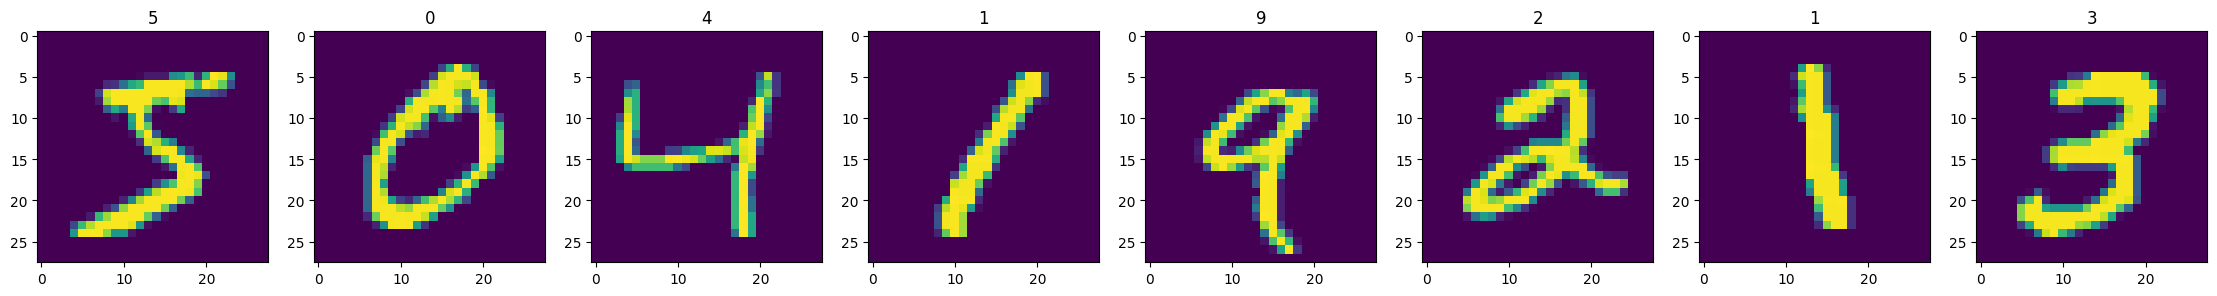

In [10]:
fig,ax = plt.subplots(ncols = 8, figsize = (28,28))
rows = 0
for idx,img in enumerate(X_train[:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(y_train[idx])

# 1.3 Apply normalization --> all pixels between 0 - 1

In [11]:
def normalize(x):
    return x / 255

In [12]:
X_train = normalize(X_train)

# 1.4 setup data iterator to batch/prepare data

In [13]:
df = tf.data.Dataset.from_tensor_slices((X_train,y_train))

In [14]:
df = df.batch(32)

In [15]:
data_iterator = df.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

In [32]:
batch[0].shape

(32, 28, 28)

# 1.4 Create train and val data 

### train size ~ 50k images
### val size ~ 10k images
### test size ~ 10k images

In [23]:
train_size = 1562
val_size = len(df) - train_size

In [24]:
train = df.take(train_size)
val = df.skip(train_size).take(val_size)

# 2 Build CNN model

In [28]:
from tensorflow.keras.models import Sequential

In [34]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, BatchNormalization, ReLU, Dropout

In [64]:
def Model():
    model = Sequential()

    # First Layer
    model.add(Conv2D(16,(3,3),1,activation = "relu",input_shape = (28,28,1)))
    model.add(MaxPooling2D())
    model.add((ReLU(0.2)))

    # Second Layer
    model.add(Conv2D(16,(3,3),1,activation = "relu",input_shape = (28,28)))
    model.add((ReLU(0.2)))

    # Third Layer
    model.add(Flatten())
    model.add(Dense(128,activation = "sigmoid"))
    model.add(Dropout(0.2))

    # Final layer
    model.add(Dense(10,activation = "softmax"))
    return model


In [88]:
model = Model()
model.compile('adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 re_lu_18 (ReLU)             (None, 13, 13, 16)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 11, 11, 16)        2320      
                                                                 
 re_lu_19 (ReLU)             (None, 11, 11, 16)        0         
                                                                 
 flatten_9 (Flatten)         (None, 1936)              0         
                                                     

# Test the model

In [78]:
results = 'results'

In [79]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=results)

In [89]:
hist = model.fit(train,epochs=20,validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/20
1562/1562 [==============================] - 11s 4ms/step - loss: 0.3574 - accuracy: 0.9023 - val_loss: 0.1041 - val_accuracy: 0.9731
Epoch 2/20
1562/1562 [==============================] - 6s 4ms/step - loss: 0.1084 - accuracy: 0.9683 - val_loss: 0.0706 - val_accuracy: 0.9809
Epoch 3/20
1562/1562 [==============================] - 6s 4ms/step - loss: 0.0782 - accuracy: 0.9769 - val_loss: 0.0566 - val_accuracy: 0.9841
Epoch 4/20
1562/1562 [==============================] - 6s 4ms/step - loss: 0.0615 - accuracy: 0.9816 - val_loss: 0.0518 - val_accuracy: 0.9847
Epoch 5/20
1562/1562 [==============================] - 6s 4ms/step - loss: 0.0498 - accuracy: 0.9852 - val_loss: 0.0448 - val_accuracy: 0.9873
Epoch 6/20
1562/1562 [==============================] - 6s 4ms/step - loss: 0.0411 - accuracy: 0.9874 - val_loss: 0.0455 - val_accuracy: 0.9873
Epoch 7/20
1562/1562 [==============================] - 6s 4ms/step - loss: 0.0353 - accuracy: 0.9895 - val_loss: 0.0422 - val_accuracy

# Test on test set

In [92]:
X_test = normalize(X_test)

In [93]:
df_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [94]:
df_test = df_test.batch(32)

In [95]:
data_iterator_test = df_test.as_numpy_iterator()

In [96]:
len(df_test)

313

In [98]:
test = df.take(313)

In [102]:
for batch in test.as_numpy_iterator():
    X,y = batch
    print(model.evaluate(X,y))
    

1/1 [==============================] - 0s 27ms/step - loss: 0.0020 - accuracy: 1.0000
[0.0019897951278835535, 1.0]
1/1 [==============================] - 0s 28ms/step - loss: 0.0081 - accuracy: 1.0000
[0.008093206211924553, 1.0]
1/1 [==============================] - 0s 26ms/step - loss: 0.0099 - accuracy: 1.0000
[0.009896855801343918, 1.0]
1/1 [==============================] - 0s 33ms/step - loss: 5.5607e-04 - accuracy: 1.0000
[0.0005560675053857267, 1.0]
1/1 [==============================] - 0s 24ms/step - loss: 0.0168 - accuracy: 1.0000
[0.01683449186384678, 1.0]
1/1 [==============================] - 0s 23ms/step - loss: 0.0632 - accuracy: 0.9688
[0.06324878334999084, 0.96875]
1/1 [==============================] - 0s 23ms/step - loss: 0.0021 - accuracy: 1.0000
[0.002063431078568101, 1.0]
1/1 [==============================] - 0s 26ms/step - loss: 0.0013 - accuracy: 1.0000
[0.0012650478165596724, 1.0]
1/1 [==============================] - 0s 23ms/step - loss: 0.0014 - accuracy: 

In [105]:
model.save("CNN_model_of_184.h5")